In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 22386.85it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>

In [6]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis= -1)
densor1 = Dense(10, activation= 'tanh')
densor2 = Dense(1, activation= 'relu')
activator = Activation(softmax, name= 'attention_weights') # custom softmax(axis = 1)
dotor = Dot(axes= 1)

In [7]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, a])
    
    return context

In [8]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state 's'

# global variable
post_activation_LSTM_cell = LSTM(n_s, return_state= True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [9]:
def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    
    a = Bidirectional(LSTM(n_a, return_sequences= True))(X)
    
    for t in range(Ty):
        context = one_step_attention(a, s)
        _, s, c, = post_activation_LSTM_cell(context, initial_state=[s, c])
        out = output_layer(s)
        outputs.append(out)
        
    model = Model(inputs= [X, s0, c0], outputs=outputs)
    
    return model

In [10]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 37)]             0         []                            
                                                                                                  
 s0 (InputLayer)             [(None, 64)]                 0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 30, 64)               17920     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 repeat_vector (RepeatVecto  (None, 30, 64)               0         ['s0[0][0]',              

                                                                     'attention_weights[4][0]',   
                                                                     'bidirectional[0][0]',       
                                                                     'attention_weights[5][0]',   
                                                                     'bidirectional[0][0]',       
                                                                     'attention_weights[6][0]',   
                                                                     'bidirectional[0][0]',       
                                                                     'attention_weights[7][0]',   
                                                                     'bidirectional[0][0]',       
                                                                     'attention_weights[8][0]',   
                                                                     'bidirectional[0][0]',       
          

In [12]:
opt = Adam(learning_rate=0.005, beta_1= 0.9, beta_2= 0.999, decay= 0.01)
model.compile(loss= 'categorical_crossentropy', optimizer= opt, metrics= ['accuracy'])

In [13]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [14]:
model.fit([Xoh, s0, c0], outputs, epochs=15, batch_size=100)

Epoch 1/15
100/100 [==============================] - 37s 63ms/step - loss: 16.8228 - dense_2_loss: 1.1971 - dense_2_1_loss: 0.9871 - dense_2_2_loss: 1.7948 - dense_2_3_loss: 2.6734 - dense_2_4_loss: 0.7814 - dense_2_5_loss: 1.3516 - dense_2_6_loss: 2.6826 - dense_2_7_loss: 1.0133 - dense_2_8_loss: 1.7234 - dense_2_9_loss: 2.6182 - dense_2_accuracy: 0.5054 - dense_2_1_accuracy: 0.7021 - dense_2_2_accuracy: 0.2867 - dense_2_3_accuracy: 0.0947 - dense_2_4_accuracy: 0.9144 - dense_2_5_accuracy: 0.3090 - dense_2_6_accuracy: 0.0530 - dense_2_7_accuracy: 0.8629 - dense_2_8_accuracy: 0.2284 - dense_2_9_accuracy: 0.0910
Epoch 2/15
100/100 [==============================] - 7s 67ms/step - loss: 9.3310 - dense_2_loss: 0.1726 - dense_2_1_loss: 0.1341 - dense_2_2_loss: 1.1145 - dense_2_3_loss: 2.2070 - dense_2_4_loss: 0.0201 - dense_2_5_loss: 0.3547 - dense_2_6_loss: 1.9893 - dense_2_7_loss: 0.0193 - dense_2_8_loss: 1.0912 - dense_2_9_loss: 2.2284 - dense_2_accuracy: 0.9597 - dense_2_1_accuracy: 0

In [15]:
model.load_weights('models/model.h5')

In [17]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis= -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print('source:', example)
    print('output:', ''.join(output), '\n')

1/1 [==============================] - 8s 8s/step
source: 3 May 1979
output: 1979-05-33 

1/1 [==============================] - 0s 29ms/step
source: 5 April 09
output: 2009-04-05 

1/1 [==============================] - 0s 33ms/step
source: 21th of August 2016
output: 2016-08-20 

1/1 [==============================] - 0s 32ms/step
source: Tue 10 Jul 2007
output: 2007-07-10 

1/1 [==============================] - 0s 29ms/step
source: Saturday May 9 2018
output: 2018-05-09 

1/1 [==============================] - 0s 29ms/step
source: March 3 2001
output: 2001-03-03 

1/1 [==============================] - 0s 28ms/step
source: March 3rd 2001
output: 2001-03-03 

1/1 [==============================] - 0s 30ms/step
source: 1 March 2001
output: 2001-03-01 



1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

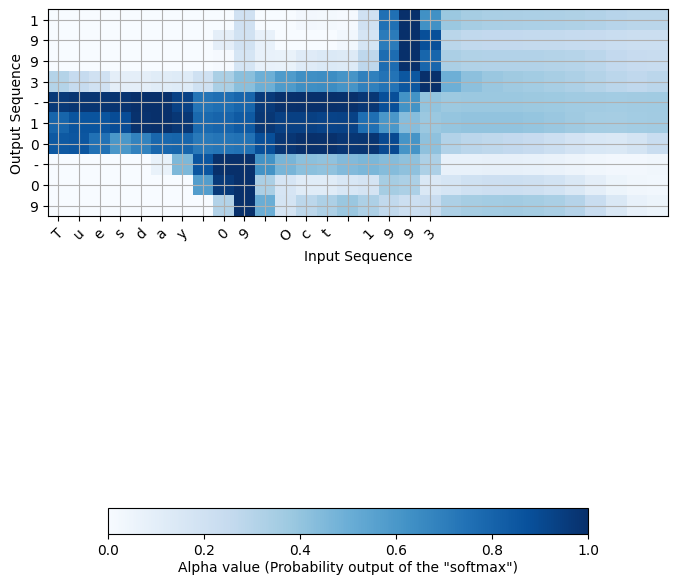

In [18]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);